<a href="https://colab.research.google.com/github/mhsnur/TESIS-S2-Geomatika-FT-UGM-Muhsin-Nur-Alamsyah/blob/main/RS_RANSAC/RS_RANSAC_GSP_UGM/RANSAC_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================================
# INSTALL LIBRARY (sekali saja di Colab)
# =========================================
!pip install open3d laspy alphashape shapely descartes --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 149.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.3 MB/s eta 0:00:00


In [ ]:
# =========================================
# IMPORT LIBRARY
# =========================================
import open3d as o3d
import numpy as np
import laspy
import alphashape
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import random


In [ ]:
# Fungsi warna acak
def get_random_color():
    return [random.random(), random.random(), random.random()]

# Fungsi pembanding normal
def is_similar_normal(n1, n2, threshold=0.98):
    return abs(np.dot(n1, n2)) > threshold


In [ ]:
# Path file LAS
las_path = "/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/RS/B2.las"

# Baca file LAS
las = laspy.read(las_path)
points = np.vstack((las.x, las.y, las.z)).transpose()

# Konversi ke PointCloud Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Downsampling untuk percepatan
pcd = pcd.voxel_down_sample(voxel_size=0.3)  # bisa ubah ke 0.2 jika ingin detail

# Salin
cloud = pcd


In [ ]:
# =========================================
# RANSAC MULTI-PLANE )
# =========================================

import alphashape
from shapely.geometry import MultiPolygon

# ----------------------
# Parameter RANSAC & Filter
# ----------------------
distance_threshold = 0.13
ransac_n = 4
num_iterations = 10000
min_inlier_ratio = 0.015
min_area_threshold = 2.0    # m² jika data dalam meter
min_points_per_plane = 20   # titik minimum agar bidang disimpan

# ----------------------
# Variabel hasil
# ----------------------
plane_list = []
plane_colors = []
normals = []
is_valid_list = []

# ----------------------
# RANSAC Loop
# ----------------------
while True:
    print(f"📌 Titik tersisa: {len(cloud.points)}")
    if len(cloud.points) < 250:
        break

    plane_model, inliers = cloud.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )

    inlier_ratio = len(inliers) / len(cloud.points)
    if inlier_ratio < min_inlier_ratio:
        print("🚫 Bidang terlalu kecil (rasio inlier), hentikan iterasi.")
        break

    plane = cloud.select_by_index(inliers)
    color = get_random_color()

    # Cek jumlah titik minimal
    if len(plane.points) < min_points_per_plane:
        print(f"⚠️ Bidang dibuang (hanya {len(plane.points)} titik)")
        cloud = cloud.select_by_index(inliers, invert=True)
        continue

    # Cek area alphashape
    pts = np.asarray(plane.points)
    pts_xy = pts[:, :2]

    try:
        shape = alphashape.alphashape(pts_xy, alpha=0.22)
        if isinstance(shape, MultiPolygon):
            shape = max(shape.geoms, key=lambda p: p.area)
        area = shape.area
        is_valid = area >= min_area_threshold

        if not is_valid:
            print(f"⚠️ Bidang dilewati (area terlalu kecil: {area:.2f} m²)")
        else:
            print(f"✅ Bidang disimpan (area: {area:.2f} m²)")

    except Exception as e:
        print(f"⚠️ Gagal hitung alphashape: {e}")
        is_valid = False

    if is_valid:
        plane.paint_uniform_color(color)
        plane_list.append(plane)
        plane_colors.append(color)
        normals.append(plane_model[:3] / np.linalg.norm(plane_model[:3]))
        is_valid_list.append(True)

    # Hapus dari cloud walau valid atau tidak
    cloud = cloud.select_by_index(inliers, invert=True)


📌 Titik tersisa: 63063


✅ Bidang disimpan (area: 458.35 m²)
📌 Titik tersisa: 56973
✅ Bidang disimpan (area: 498.60 m²)
📌 Titik tersisa: 51806
✅ Bidang disimpan (area: 771.82 m²)
📌 Titik tersisa: 47977
✅ Bidang disimpan (area: 492.88 m²)
📌 Titik tersisa: 43026
✅ Bidang disimpan (area: 241.44 m²)
📌 Titik tersisa: 39541
✅ Bidang disimpan (area: 252.00 m²)
📌 Titik tersisa: 36309
✅ Bidang disimpan (area: 260.43 m²)
📌 Titik tersisa: 33767
✅ Bidang disimpan (area: 251.68 m²)
📌 Titik tersisa: 30705
✅ Bidang disimpan (area: 246.75 m²)
📌 Titik tersisa: 27983
✅ Bidang disimpan (area: 368.52 m²)
📌 Titik tersisa: 26005
✅ Bidang disimpan (area: 245.03 m²)
📌 Titik tersisa: 23777
✅ Bidang disimpan (area: 107.96 m²)
📌 Titik tersisa: 21848
✅ Bidang disimpan (area: 189.89 m²)
📌 Titik tersisa: 20124
✅ Bidang disimpan (area: 221.40 m²)
📌 Titik tersisa: 17898
✅ Bidang disimpan (area: 119.39 m²)
📌 Titik tersisa: 15950
✅ Bidang disimpan (area: 309.32 m²)
📌 Titik tersisa: 14193
✅ Bidang disimpan (area: 97.50 m²)
📌 Titik tersisa: 1258

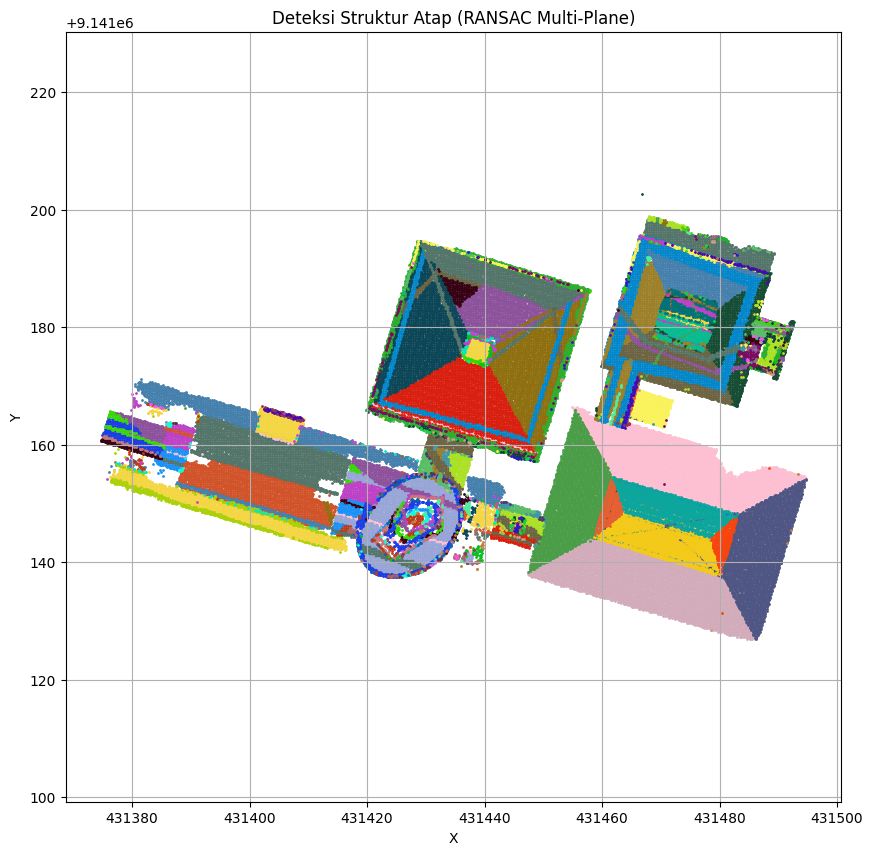

In [ ]:
plt.figure(figsize=(10, 10))

for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    plt.scatter(pts[:, 0], pts[:, 1], s=1, color=color)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Deteksi Struktur Atap (RANSAC Multi-Plane)")
plt.axis("equal")
plt.grid(True)
plt.show()


In [ ]:
outlines = []
outline_colors = []

for idx, plane in enumerate(plane_list):
    pts = np.asarray(plane.points)
    pts_xy = pts[:, :2]  # Proyeksi ke XY

    try:
        alpha = 0.45
        shape = alphashape.alphashape(pts_xy, alpha)

        if isinstance(shape, MultiPolygon):
            largest = max(shape.geoms, key=lambda p: p.area)
            outlines.append(largest)
        elif isinstance(shape, Polygon):
            outlines.append(shape)
        else:
            print(f"⚠️ Plane {idx} menghasilkan bukan polygon.")
            continue

        outline_colors.append(plane_colors[idx])

    except Exception as e:
        print(f"❌ Gagal alphashape untuk plane {idx}: {e}, fallback ke convex hull.")
        try:
            from shapely.geometry import MultiPoint
            hull = MultiPoint(pts_xy).convex_hull
            outlines.append(hull)
            outline_colors.append(plane_colors[idx])
        except Exception as ee:
            print(f"‼️ Gagal convex hull juga untuk plane {idx}: {ee}")
            continue


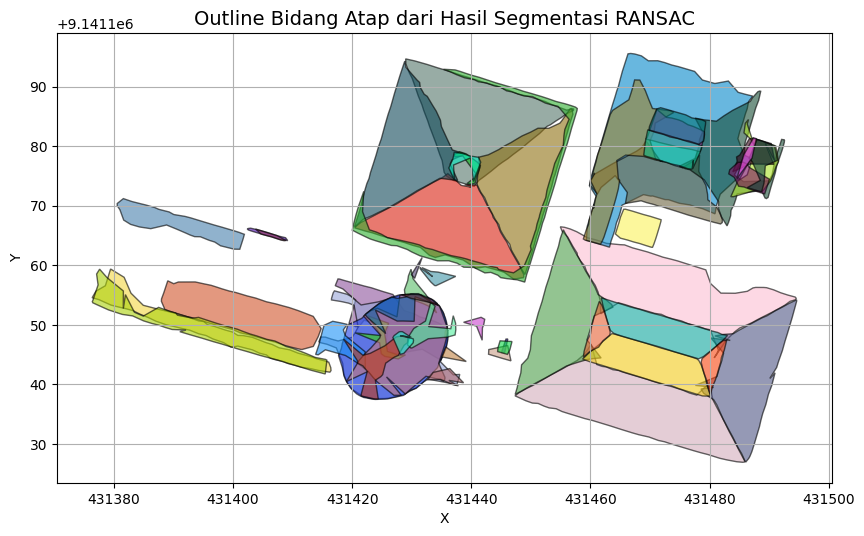

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for poly, color in zip(outlines, outline_colors):
    x, y = poly.exterior.xy
    ax.fill(x, y, color=color, alpha=0.6, edgecolor='black')

ax.set_aspect('equal')
ax.set_title("Outline Bidang Atap dari Hasil Segmentasi RANSAC", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


In [ ]:
import geopandas as gpd

# Buat GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"id": list(range(1, len(outlines)+1))},
    geometry=outlines,
    crs="EPSG:32749"   # ganti sesuai CRS kamu
)

# Simpan ke GeoJSON
output_path = "/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/RS/B2.geojson"
gdf.to_file(output_path, driver="GeoJSON")

print(f"✅ GeoJSON berhasil disimpan ke: {output_path}")


✅ GeoJSON berhasil disimpan ke: /content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/RS/B2.geojson


In [ ]:
from shapely.geometry import LineString, MultiPoint

outline_lines = []  # simpan semua garis outline

for idx, plane in enumerate(plane_list):
    pts = np.asarray(plane.points)
    pts_xy = pts[:, :2]  # hanya X dan Y

    try:
        alpha = 0.5
        shape = alphashape.alphashape(pts_xy, alpha)

        if isinstance(shape, MultiPolygon):
            largest = max(shape.geoms, key=lambda p: p.area)
            exterior = largest.exterior
        elif isinstance(shape, Polygon):
            exterior = shape.exterior
        else:
            print(f"⚠️ Plane {idx} tidak menghasilkan polygon.")
            continue

        # Simpan garis (LineString)
        line = LineString(exterior.coords)
        outline_lines.append((line, plane_colors[idx]))

    except Exception as e:
        print(f"❌ Alphashape gagal untuk plane {idx}, fallback ke convex hull.")
        try:
            hull = MultiPoint(pts_xy).convex_hull
            line = LineString(hull.exterior.coords)
            outline_lines.append((line, plane_colors[idx]))
        except Exception as ee:
            print(f"‼️ Gagal juga convex hull: {ee}")
            continue


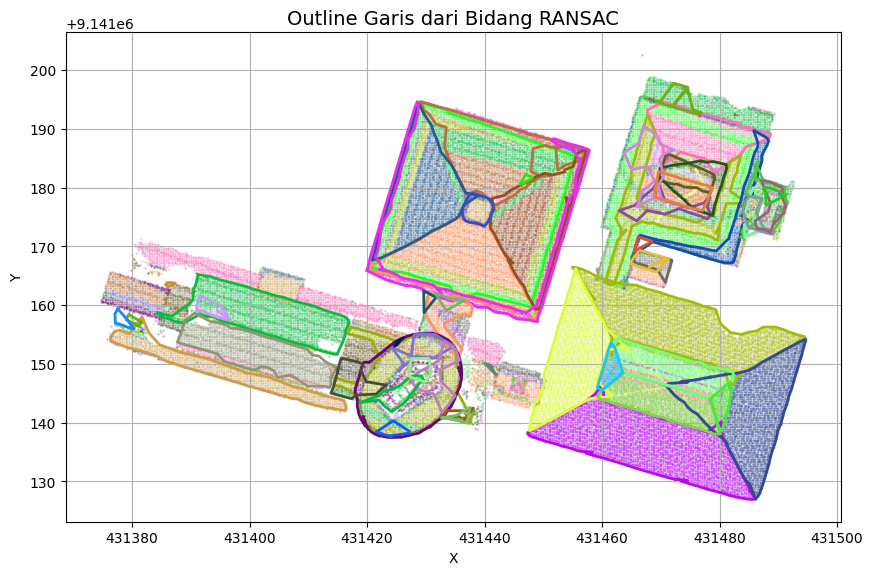

In [ ]:
# =============================================
# TAMPILKAN OUTLINE LINE DENGAN MATPLOTLIB
# =============================================
fig, ax = plt.subplots(figsize=(10, 10))

# Plot garis dari alphashape
for line, color in outline_lines:
    x, y = line.xy
    ax.plot(x, y, color=color, linewidth=2)

# Tambahkan titik point cloud untuk konteks
for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    ax.scatter(pts[:, 0], pts[:, 1], s=0.5, color=color, alpha=0.3)

ax.set_aspect('equal')
ax.set_title("Outline Garis dari Bidang RANSAC", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


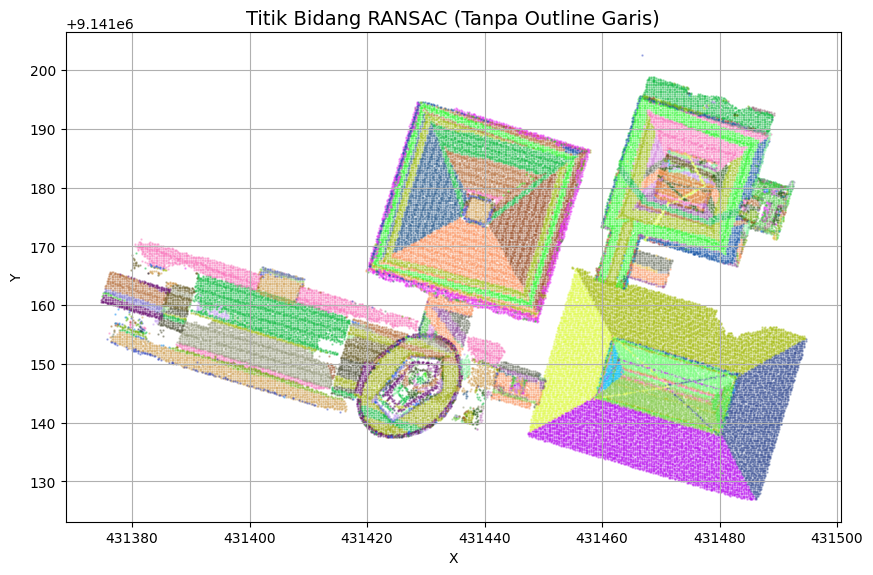

In [ ]:
# =============================================
# TAMPILKAN TITIK SAJA DENGAN MATPLOTLIB
# (Tanpa garis/outline LineString)
# =============================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Hanya plot titik point cloud hasil RANSAC
for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    ax.scatter(pts[:, 0], pts[:, 1], s=0.5, color=color, alpha=0.4)

ax.set_aspect('equal')
ax.set_title("Titik Bidang RANSAC (Tanpa Outline Garis)", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()
